In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from keras import optimizers
from keras import losses
from keras import metrics
from keras import regularizers
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorboard.plugins.hparams import api as hp
from sklearn.model_selection import train_test_split, GridSearchCV
from scikeras.wrappers import KerasClassifier


In [2]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784
k = 10000 # кількість даних під тест

In [3]:
# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data= np.c_[(x_train), y_train]
np.random.shuffle(train_data)

train_data_X = train_data[:, :-1]
train_data_y = train_data[:, -1]

train_data_y = to_categorical(train_data_y, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

In [4]:
x_val = train_data_X[:k]
partial_x_train = train_data_X[k:]

y_val = train_data_y[:k]
partial_y_train = train_data_y[k:]

# units = [1000, 2000, 3000]
# batches = [1024, 2048]
# dropouts = [0.0, 0.1, 0,2]
activations = ['relu', 'leaky_relu', 'softplus', 'gelu', 'mish', 'tanh']

In [5]:
def create_model(units=1000, activation='relu', dropout=0.0, regularizer=0.0):
    model = Sequential([
        Dense(units, activation=activation, input_shape=(num_features,), kernel_regularizer=regularizers.L2(regularizer)),
        Dropout(0.5),
        Dense(num_classes, activation='sigmoid')], 
        name=f"model_{activation}_reg-{regularizer}"
    )

    model.compile(
        optimizer=optimizers.legacy.Adam(),
        loss=metrics.categorical_crossentropy,
        metrics=['accuracy']
    )
    return model

In [6]:
def create_plot(history):

    history = history.history
    loss_values = history['loss']
    val_loss_values = history['val_loss']

    epochs = range(1, len(history['accuracy']) + 1)

    plt.plot(epochs, loss_values, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.clf()
    val_acc_values = history['val_accuracy']
    plt.plot(epochs, history['accuracy'], 'bo', label='Training acc')
    plt.plot(epochs, history['val_accuracy'], 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

In [11]:
!rm -rf ./logs/

In [8]:
def create_models(units=100, batch=512, dropout=0.0, regularizer=0.0):
    
    total_test_accuracy = 0
    history_dict = {}

    for activation in activations:

        print("")
        print(f'units: {units}, batch: {batch}, activation: {activation}, regularizer: {regularizer}')

        model = create_model(units, activation, dropout, regularizer)


        log_folder = f"./logs/fit/model_{activation}/units-{units}/drop-{dropout}"
        early_stopping = EarlyStopping(patience=20, monitor='val_accuracy')
        checkpoint = ModelCheckpoint('best_model_checkpoint.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=0)
        tensorboard = TensorBoard(log_dir=log_folder)


        history = model.fit(
            partial_x_train,
            partial_y_train,
            epochs=120,
            batch_size=batch,
            validation_data=(x_val, y_val),
            callbacks=[checkpoint, early_stopping, tensorboard]

        )

        test_loss, test_accuracy = model.evaluate(x_test, y_test)
        print('Test loss: ', test_loss)
        print('Test accuracy: ', test_accuracy)

        if test_accuracy > total_test_accuracy:
            total_test_accuracy = test_accuracy
            history_dict = history

            model.save("best_model.keras")
            model.summary()

        create_plot(history_dict)
        
    return history_dict


units: 1000, batch: 1024, activation: relu, regularizer: 0.0
Epoch 1/120
49/49 [==============================] - 1s 17ms/step - loss: 0.9177 - accuracy: 0.6877 - val_loss: 0.5393 - val_accuracy: 0.8139
Epoch 2/120
49/49 [==============================] - 1s 14ms/step - loss: 0.6060 - accuracy: 0.7953 - val_loss: 0.4709 - val_accuracy: 0.8390
Epoch 3/120
49/49 [==============================] - 1s 14ms/step - loss: 0.5519 - accuracy: 0.8129 - val_loss: 0.4563 - val_accuracy: 0.8428
Epoch 4/120
49/49 [==============================] - 1s 14ms/step - loss: 0.5222 - accuracy: 0.8228 - val_loss: 0.4452 - val_accuracy: 0.8479
Epoch 5/120
49/49 [==============================] - 1s 14ms/step - loss: 0.4994 - accuracy: 0.8257 - val_loss: 0.4280 - val_accuracy: 0.8548
Epoch 6/120
49/49 [==============================] - 1s 13ms/step - loss: 0.4898 - accuracy: 0.8329 - val_loss: 0.4341 - val_accuracy: 0.8507
Epoch 7/120
49/49 [==============================] - 1s 14ms/step - loss: 0.4820 - acc

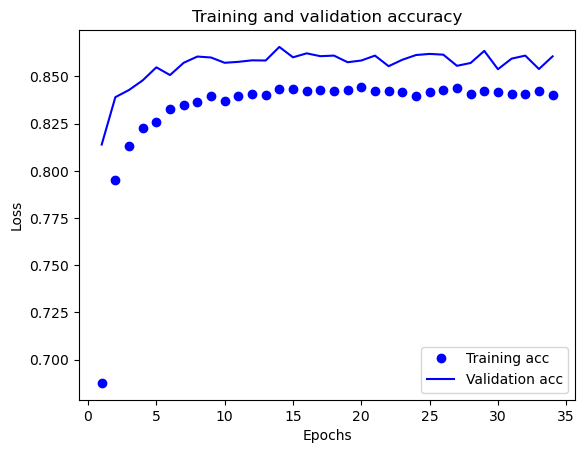


units: 1000, batch: 1024, activation: leaky_relu, regularizer: 0.0
Epoch 1/120
49/49 [==============================] - 1s 17ms/step - loss: 0.7901 - accuracy: 0.7207 - val_loss: 0.5046 - val_accuracy: 0.8293
Epoch 2/120
49/49 [==============================] - 1s 14ms/step - loss: 0.4958 - accuracy: 0.8272 - val_loss: 0.4346 - val_accuracy: 0.8517
Epoch 3/120
49/49 [==============================] - 1s 14ms/step - loss: 0.4477 - accuracy: 0.8431 - val_loss: 0.4053 - val_accuracy: 0.8624
Epoch 4/120
49/49 [==============================] - 1s 14ms/step - loss: 0.4191 - accuracy: 0.8546 - val_loss: 0.3877 - val_accuracy: 0.8634
Epoch 5/120
49/49 [==============================] - 1s 14ms/step - loss: 0.4012 - accuracy: 0.8575 - val_loss: 0.3742 - val_accuracy: 0.8690
Epoch 6/120
49/49 [==============================] - 1s 14ms/step - loss: 0.3838 - accuracy: 0.8643 - val_loss: 0.3653 - val_accuracy: 0.8739
Epoch 7/120
49/49 [==============================] - 1s 15ms/step - loss: 0.3716

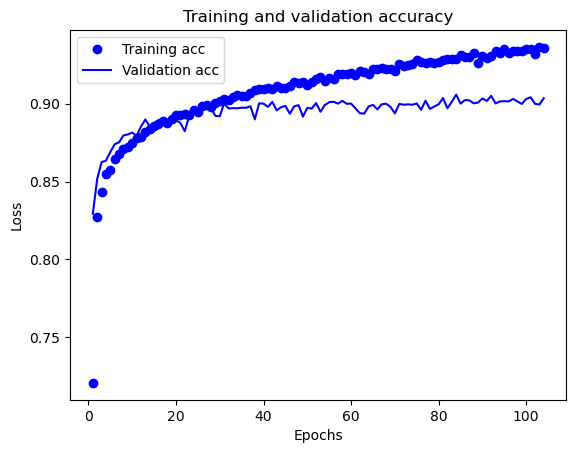


units: 1000, batch: 1024, activation: softplus, regularizer: 0.0
Epoch 1/120
49/49 [==============================] - 1s 23ms/step - loss: 0.9958 - accuracy: 0.6471 - val_loss: 0.5538 - val_accuracy: 0.8037
Epoch 2/120
49/49 [==============================] - 1s 20ms/step - loss: 0.5843 - accuracy: 0.7911 - val_loss: 0.4823 - val_accuracy: 0.8283
Epoch 3/120
49/49 [==============================] - 1s 20ms/step - loss: 0.5253 - accuracy: 0.8124 - val_loss: 0.4516 - val_accuracy: 0.8387
Epoch 4/120
49/49 [==============================] - 1s 23ms/step - loss: 0.4903 - accuracy: 0.8237 - val_loss: 0.4279 - val_accuracy: 0.8496
Epoch 5/120
49/49 [==============================] - 1s 20ms/step - loss: 0.4708 - accuracy: 0.8306 - val_loss: 0.4183 - val_accuracy: 0.8511
Epoch 6/120
49/49 [==============================] - 1s 20ms/step - loss: 0.4526 - accuracy: 0.8364 - val_loss: 0.4051 - val_accuracy: 0.8566
Epoch 7/120
49/49 [==============================] - 1s 20ms/step - loss: 0.4363 -

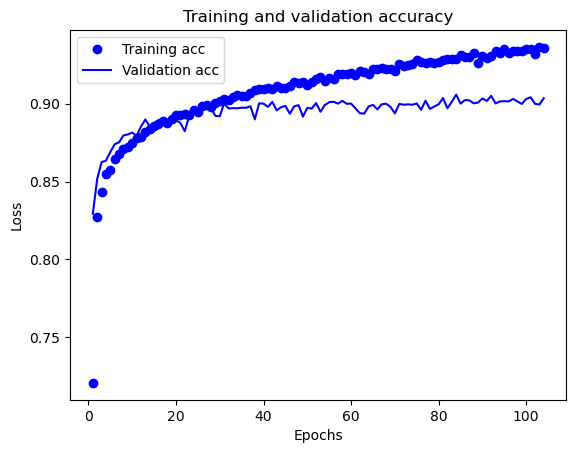


units: 1000, batch: 1024, activation: gelu, regularizer: 0.0
Epoch 1/120
49/49 [==============================] - 1s 20ms/step - loss: 0.7662 - accuracy: 0.7324 - val_loss: 0.4925 - val_accuracy: 0.8293
Epoch 2/120
49/49 [==============================] - 1s 16ms/step - loss: 0.4843 - accuracy: 0.8321 - val_loss: 0.4328 - val_accuracy: 0.8504
Epoch 3/120
49/49 [==============================] - 1s 16ms/step - loss: 0.4359 - accuracy: 0.8477 - val_loss: 0.4004 - val_accuracy: 0.8573
Epoch 4/120
49/49 [==============================] - 1s 15ms/step - loss: 0.4042 - accuracy: 0.8569 - val_loss: 0.3732 - val_accuracy: 0.8689
Epoch 5/120
49/49 [==============================] - 1s 18ms/step - loss: 0.3868 - accuracy: 0.8611 - val_loss: 0.3584 - val_accuracy: 0.8744
Epoch 6/120
49/49 [==============================] - 1s 15ms/step - loss: 0.3634 - accuracy: 0.8692 - val_loss: 0.3425 - val_accuracy: 0.8771
Epoch 7/120
49/49 [==============================] - 1s 15ms/step - loss: 0.3553 - acc

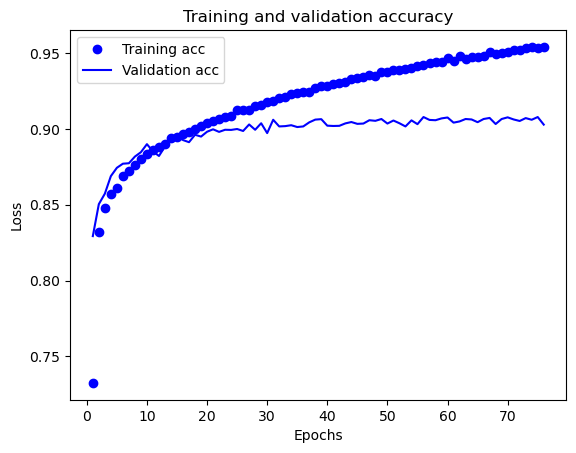


units: 1000, batch: 1024, activation: mish, regularizer: 0.0
Epoch 1/120
49/49 [==============================] - 2s 45ms/step - loss: 0.7594 - accuracy: 0.7346 - val_loss: 0.4891 - val_accuracy: 0.8338
Epoch 2/120
49/49 [==============================] - 1s 22ms/step - loss: 0.4975 - accuracy: 0.8239 - val_loss: 0.4358 - val_accuracy: 0.8503
Epoch 3/120
49/49 [==============================] - 1s 23ms/step - loss: 0.4457 - accuracy: 0.8423 - val_loss: 0.4064 - val_accuracy: 0.8576
Epoch 4/120
49/49 [==============================] - 1s 22ms/step - loss: 0.4205 - accuracy: 0.8496 - val_loss: 0.3830 - val_accuracy: 0.8666
Epoch 5/120
49/49 [==============================] - 1s 21ms/step - loss: 0.4028 - accuracy: 0.8561 - val_loss: 0.3732 - val_accuracy: 0.8697
Epoch 6/120
49/49 [==============================] - 1s 21ms/step - loss: 0.3834 - accuracy: 0.8623 - val_loss: 0.3701 - val_accuracy: 0.8672
Epoch 7/120
49/49 [==============================] - 1s 21ms/step - loss: 0.3760 - acc

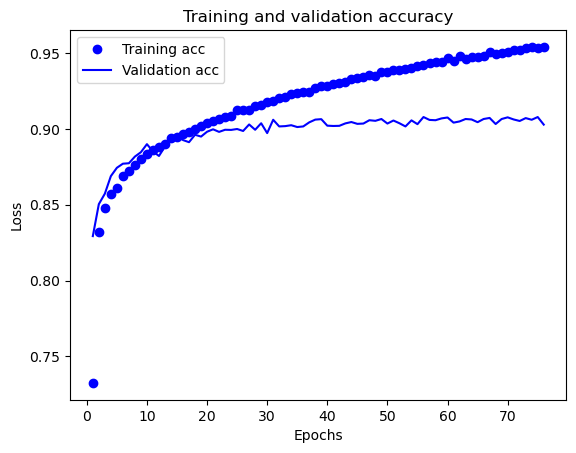


units: 1000, batch: 1024, activation: tanh, regularizer: 0.0
Epoch 1/120
49/49 [==============================] - 1s 19ms/step - loss: 0.7964 - accuracy: 0.7206 - val_loss: 0.4911 - val_accuracy: 0.8323
Epoch 2/120
49/49 [==============================] - 1s 16ms/step - loss: 0.5104 - accuracy: 0.8202 - val_loss: 0.4652 - val_accuracy: 0.8361
Epoch 3/120
49/49 [==============================] - 1s 14ms/step - loss: 0.4693 - accuracy: 0.8346 - val_loss: 0.4246 - val_accuracy: 0.8513
Epoch 4/120
49/49 [==============================] - 1s 14ms/step - loss: 0.4562 - accuracy: 0.8385 - val_loss: 0.4127 - val_accuracy: 0.8583
Epoch 5/120
49/49 [==============================] - 1s 14ms/step - loss: 0.4350 - accuracy: 0.8477 - val_loss: 0.3994 - val_accuracy: 0.8625
Epoch 6/120
49/49 [==============================] - 1s 14ms/step - loss: 0.4240 - accuracy: 0.8491 - val_loss: 0.3944 - val_accuracy: 0.8600
Epoch 7/120
49/49 [==============================] - 1s 14ms/step - loss: 0.4094 - acc

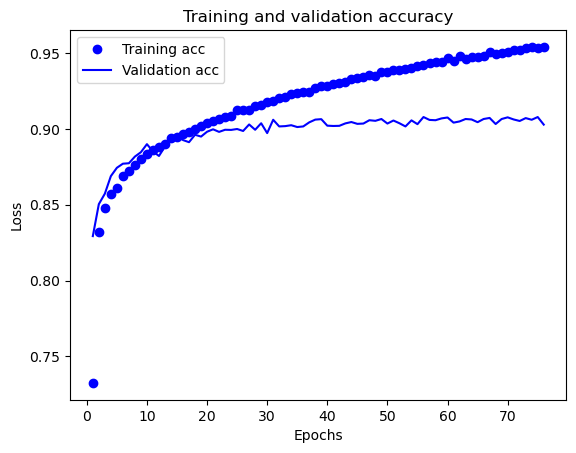

In [12]:
units = 1000
batch = 1024

history = create_models(units, batch)

In [13]:
model = keras.models.load_model("best_model.keras")
model.summary()
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test loss: {test_loss}, test accuracy: {test_accuracy}")

Model: "model_gelu_reg-0.0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 1000)              785000    
                                                                 
 dropout_9 (Dropout)         (None, 1000)              0         
                                                                 
 dense_19 (Dense)            (None, 10)                10010     
                                                                 
Total params: 795010 (3.03 MB)
Trainable params: 795010 (3.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
313/313 [==============================] - 2s 5ms/step - loss: 0.3321 - accuracy: 0.9009
Test loss: 0.3321332633495331, test accuracy: 0.9009000062942505


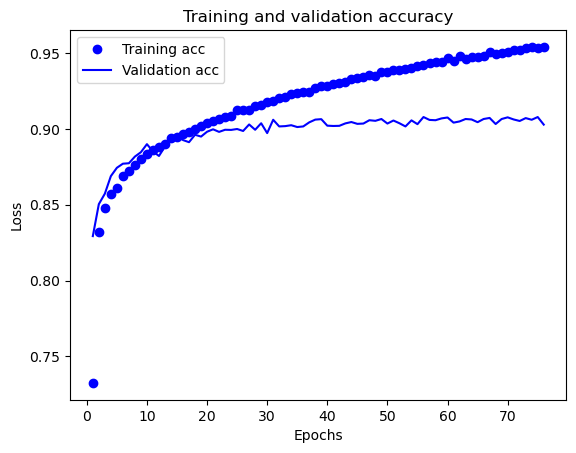

In [14]:
create_plot(history)

In [5]:
%load_ext tensorboard

In [16]:
%tensorboard --logdir logs/fit/model_gelu

#### Візьмемо ті самі дані і спробуємо збільшити точність моделі за рахунок dropout

In [81]:
units = 1000
batch = 1024
activation = "gelu"
dropout = 0.3
regularizer = 0.0


print("")
print(f'units: {units}, batch: {batch}, activation: {activation}, dropout: {dropout}, regularizer: {regularizer}')

model = create_model(units, activation, dropout, regularizer)


!rm -rf ./logs/fit/model_{activation}/units-{units}/drop-{dropout}/reg-{regularizer}/
log_folder = f"./logs/fit/model_{activation}/units-{units}/drop-{dropout}/reg-{regularizer}"

early_stopping = EarlyStopping(patience=20, monitor='val_accuracy')
checkpoint = ModelCheckpoint('best_model_checkpoint.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=0)
tensorboard = TensorBoard(log_dir=log_folder)


history = model.fit(
    partial_x_train,
    partial_y_train,
    epochs=150,
    batch_size=batch,
    validation_data=(x_val, y_val),
    callbacks=[checkpoint, early_stopping, tensorboard]

)

test_loss, test_accuracy = model.evaluate(x_test, y_test)
print('Test loss: ', test_loss)
print('Test accuracy: ', test_accuracy)


units: 1000, batch: 1024, activation: gelu, dropout: 0.3, regularizer: 0.0
Epoch 1/150
49/49 [==============================] - 2s 29ms/step - loss: 0.7645 - accuracy: 0.7356 - val_loss: 0.5057 - val_accuracy: 0.8246
Epoch 2/150
49/49 [==============================] - 1s 20ms/step - loss: 0.4911 - accuracy: 0.8272 - val_loss: 0.4332 - val_accuracy: 0.8477
Epoch 3/150
49/49 [==============================] - 1s 19ms/step - loss: 0.4338 - accuracy: 0.8468 - val_loss: 0.4008 - val_accuracy: 0.8605
Epoch 4/150
49/49 [==============================] - 1s 19ms/step - loss: 0.4128 - accuracy: 0.8523 - val_loss: 0.3860 - val_accuracy: 0.8601
Epoch 5/150
49/49 [==============================] - 1s 19ms/step - loss: 0.3852 - accuracy: 0.8634 - val_loss: 0.3687 - val_accuracy: 0.8714
Epoch 6/150
49/49 [==============================] - 1s 20ms/step - loss: 0.3668 - accuracy: 0.8682 - val_loss: 0.3455 - val_accuracy: 0.8782
Epoch 7/150
49/49 [==============================] - 1s 19ms/step - loss

In [82]:
model.save("best_model_gelu.keras")
model.summary()

Model: "model_gelu_reg-0.0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_112 (Dense)           (None, 1000)              785000    
                                                                 
 dropout_56 (Dropout)        (None, 1000)              0         
                                                                 
 dense_113 (Dense)           (None, 10)                10010     
                                                                 
Total params: 795010 (3.03 MB)
Trainable params: 795010 (3.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [83]:
%tensorboard --logdir logs/fit/model_gelu/units-1000/drop-0.3

### на графіках можна помітити перенавчання

In [86]:
units = 1000
batch = 1024
activation = "gelu"
dropout = 0.3
regularizer = 0.000001


print("")
print(f'units: {units}, batch: {batch}, activation: {activation}, dropout: {dropout}, regularizer: {regularizer}')

model = create_model(units, activation, dropout, regularizer)

!rm -rf ./logs/fit/model_{activation}/units-{units}/drop-{dropout}/reg-{regularizer}/
log_folder = f"./logs/fit/model_{activation}/units-{units}/drop-{dropout}/reg-{regularizer}"

early_stopping = EarlyStopping(patience=20, monitor='val_accuracy')
checkpoint = ModelCheckpoint('best_model_checkpoint.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=0)
tensorboard = TensorBoard(log_dir=log_folder)


history = model.fit(
    partial_x_train,
    partial_y_train,
    epochs=100,
    batch_size=batch,
    validation_data=(x_val, y_val),
    callbacks=[checkpoint, early_stopping, tensorboard]

)

test_loss, test_accuracy = model.evaluate(x_test, y_test)
print('Test loss: ', test_loss)
print('Test accuracy: ', test_accuracy)


units: 1000, batch: 1024, activation: gelu, dropout: 0.3, regularizer: 1e-06
Epoch 1/100
49/49 [==============================] - 2s 36ms/step - loss: 0.7693 - accuracy: 0.7348 - val_loss: 0.5136 - val_accuracy: 0.8235
Epoch 2/100
49/49 [==============================] - 1s 25ms/step - loss: 0.4925 - accuracy: 0.8282 - val_loss: 0.4394 - val_accuracy: 0.8470
Epoch 3/100
49/49 [==============================] - 1s 24ms/step - loss: 0.4418 - accuracy: 0.8437 - val_loss: 0.4047 - val_accuracy: 0.8579
Epoch 4/100
49/49 [==============================] - 1s 23ms/step - loss: 0.4154 - accuracy: 0.8528 - val_loss: 0.3839 - val_accuracy: 0.8647
Epoch 5/100
49/49 [==============================] - 1s 24ms/step - loss: 0.3927 - accuracy: 0.8590 - val_loss: 0.3692 - val_accuracy: 0.8667
Epoch 6/100
49/49 [==============================] - 1s 23ms/step - loss: 0.3691 - accuracy: 0.8676 - val_loss: 0.3525 - val_accuracy: 0.8737
Epoch 7/100
49/49 [==============================] - 1s 23ms/step - lo

In [9]:
%tensorboard --logdir logs/fit/model_gelu/units-1000/drop-0.3/reg-1e-06/